## Which NP Data Set

Find the right NP data set. Candidates are:

* [UNPD](file:///home/pahl/comas/notebooks/sdf/unpd/UNPD_sdf.sdf): 213k cpds.
* NPs from Analyticon Discovery
* ChEMBL NPs

Also, determine the necessary standardization and the right order.
Degylcosylation is performed with KNIME.

In [3]:
%reload_ext autoreload
%autoreload 2
# def warn(*args, **kwargs):
# warn    pass  # to silence scikit-learn warnings

import warnings
warnings.filterwarnings('ignore')
# warnings.warn = warn

# Global Imports
# from collections import Counter
# import glob
from pathlib import Path
import sys

import pandas as pd
import numpy as np
# from pandarallel import pandarallel
# pandarallel.initialize()

# from scipy.stats import median_absolute_deviation as mad

from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
# from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from Contrib.NP_Score import npscorer

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Project-local Imports
PROJECT_DIR = list(Path("..").absolute().parents)[1]
sys.path.append(str(PROJECT_DIR))
import plt_style
import utils as u

Path("../tmp").mkdir(exist_ok=True)

In [4]:
fscore = npscorer.readNPModel()
def score_np(mol):
    return npscorer.scoreMol(mol, fscore)

reading NP model ...
model in


## UNPD

In [ ]:
# Takes 1:50min
unpd = u.read_sdf("/home/pahl/comas/notebooks/sdf/unpd/UNPD_sdf.sdf")
unpd.info()

In [ ]:
# unpd.to_csv("../tmp/unpd.tsv", sep="\t", index=False)
unpd = pd.read_csv("../tmp/unpd.tsv", sep="\t")
unpd.info()

### Standardization Only

#### Standardize

In [ ]:
# Takes 7min
unpd_std = u.apply_to_smiles(unpd, "Smiles", "Smiles_Std", u.standardize_mol)

In [ ]:
unpd_std.drop("Smiles", axis=1, inplace=True)
unpd_std = unpd_std.rename(columns={"Smiles_Std": "Smiles"})
unpd_std.to_csv("../tmp/unpd_std.tsv", sep="\t", index=False)
unpd_std.info()

In [ ]:
unpd_std.head()

#### Add InChiKeys and Remove Duplicates

In [ ]:
unpd_std = pd.read_csv("../tmp/unpd_std.tsv", sep="\t")

In [ ]:
# Takes 1:40min
unpd_std = u.apply_to_smiles(unpd_std, "Smiles", "InChiKey", Chem.inchi.MolToInchiKey)
unpd_std.info()

In [ ]:
unpd_std = unpd_std.drop_duplicates(subset="InChiKey")
len(unpd_std)

#### Calculate NP-Likeness Score

In [ ]:
# Takes 1:15min
unpd_std_np = u.apply_to_smiles(unpd_std, "Smiles", "NP_Score", score_np)
len(unpd_std_np)

In [ ]:
unpd_std_np = unpd_std_np[~unpd_std_np["NP_Score"].isnull()]
len(unpd_std_np)

In [ ]:
unpd_std_np["NP_Score"].plot.density();

This distribution looks much better than the one from COCONUT.

### Deglycosylation, then Standardization

#### Loading and Initial Standardization

In [ ]:
# Takes 1:40min
unpd = u.read_sdf("/home/pahl/comas/notebooks/sdf/unpd/UNPD_sdf.sdf")
unpd.info()

In [ ]:
# Initial standardization, before deglycosylation
# Takes 7:50min
unpd = u.apply_to_smiles(unpd, "Smiles", {"Smiles_Std": lambda x: u.standardize_mol(x, remove_stereo=True)})
unpd.drop("Smiles", axis=1, inplace=True)
unpd = unpd.rename(columns={"Smiles_Std": "Smiles"})

In [ ]:
# Takes 3:30min
unpd = u.filter_mols(unpd, "Smiles", ["Isotopes", "MedChemAtoms", "MinHeavyAtoms", "Duplicates"])
unpd.info()

In [ ]:
unpd.to_csv("../tmp/unpd.tsv", sep="\t", index=False)

#### Deglycosylation

Deglycosylation is performed using the KNIME Sugar Remover node (CDK).  
Here, the result of the deglycosylation is loaded again.

In [ ]:
# Reading in the output of the KNIME workflow:
unpd = pd.read_csv("../tmp/unpd_deglyco.tsv", sep="\t")
unpd.info()

In [ ]:
# 2nd standardization and cleanup after deglycosylation
# Takes 7min
unpd_std = u.apply_to_smiles(unpd, "Smiles", {"Smiles_Std": u.standardize_mol})
unpd_std.drop("Smiles", axis=1, inplace=True)
unpd_std = unpd_std.rename(columns={"Smiles_Std": "Smiles"})
unpd_std.info()

In [ ]:
unpd_std = u.filter_mols(unpd_std, "Smiles", ["MinHeavyAtoms", "MaxHeavyAtoms", "Duplicates"])

#### Final Standardization

Including tautomerization.

In [ ]:
# Takes 45min
unpd_std_tauto = u.apply_to_smiles(unpd_std, "Smiles", {"Smiles_Std": lambda x: u.standardize_mol(x, canonicalize_tautomer=True)}, parallel=True)

In [ ]:
unpd_std_tauto.drop("Smiles", axis=1, inplace=True)
unpd_std_tauto = unpd_std_tauto.rename(columns={"Smiles_Std": "Smiles"})

In [ ]:
unpd_std_tauto = u.filter_mols(unpd_std_tauto, "Smiles", "Duplicates")

In [ ]:
unpd_std_tauto.to_csv("../tmp/unpd_deglyco_std_tauto.tsv", sep="\t", index=False)
unpd_std_tauto.info()

In [ ]:

unpd_std_tauto.head()

#### Add NP Likeness Score

In [ ]:
# Takes 1:15min
# unpd_std_tauto = pd.read_csv("../tmp/unpd_deglyco_std_tauto.tsv", sep="\t")
unpd_std_tauto_np = u.apply_to_smiles(unpd_std_tauto, "Smiles", {"NP_Score": score_np})
len(unpd_std_tauto_np)

In [ ]:
unpd_std_tauto_np = unpd_std_tauto_np[~unpd_std_tauto_np["NP_Score"].isnull()]
unpd_std_tauto_np.to_csv("../tmp/unpd_deglyco_std_tauto_np.tsv", sep="\t", index=False)
len(unpd_std_tauto_np)

#### Plot Distribution

In [27]:
unpd_std_tauto_np = pd.read_csv("../tmp/unpd_deglyco_std_tauto_np.tsv", sep="\t")

In [ ]:
unpd_std_tauto_np["NP_Score"].plot.density()
plt.xlim(-5.0, 5.0);

#### Representative Subset

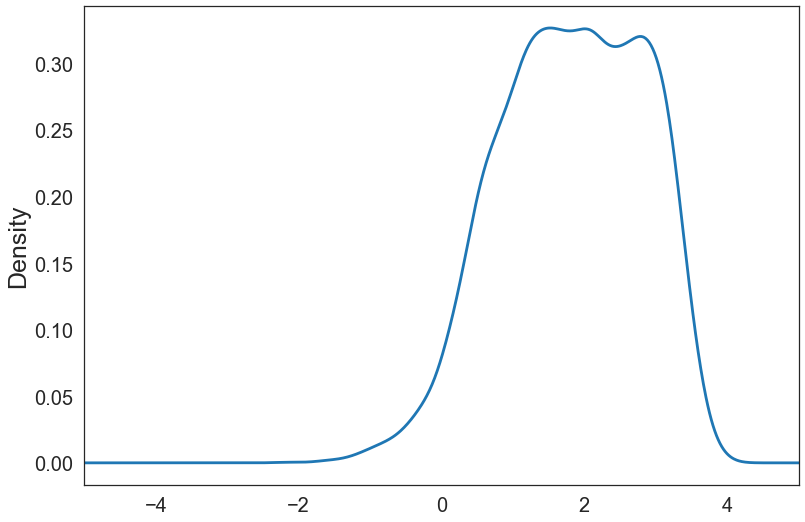

In [28]:
unpd_sub = unpd_std_tauto_np.sample(n=5000)
unpd_sub["NP_Score"].plot.density()
plt.xlim(-5.0, 5.0);

## ChEMBL NP

* 40547 cpds.
* 30655 cpds. after deglycosylation, standardization and deduplication

### Deglycosylation, then Standardization

#### Loading and Initial Standardization

In [9]:
chembl_np = pd.read_csv("/home/pahl/comas/notebooks/sdf/cpd_libs_2003/chembl_26_natprod_stereo.tsv", sep="\t")[["Chembl_Id", "Smiles"]]
chembl_np.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40547 entries, 0 to 40546
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Chembl_Id  40547 non-null  object
 1   Smiles     40525 non-null  object
dtypes: object(2)
memory usage: 633.7+ KB


In [10]:
chembl_np.head()

,Chembl_Id,Smiles
0,CHEMBL3916495,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)[C@H](OC(C)=O)...
1,CHEMBL3917534,C=C(C)[C@@H](O)CC/C(C)=C/C[C@@H]1C[C@]2(CC=C(C...
2,CHEMBL3954218,CC(=O)O[C@H]1[C@@H]2O[C@]2([C@H](C)[C@H]2CC(C)...
3,CHEMBL3956388,CC(C)=CCC[C@]1(C)[C@@H](CC=C(C)C)C[C@]2(CC=C(C...
4,CHEMBL3953960,COc1c(Br)cc(Br)cc1Oc1c(Br)c(Br)cc(Br)c1OC


In [11]:
# Initial standardization, before deglycosylation
# Takes 2:40min
chembl_np = u.apply_to_smiles(chembl_np, "Smiles", {"Smiles_Std": lambda x: u.standardize_mol(x, remove_stereo=True)})
chembl_np.drop("Smiles", axis=1, inplace=True)
chembl_np = chembl_np.rename(columns={"Smiles_Std": "Smiles"})

RDKit ERROR: [13:25:36] Explicit valence for atom # 26 B, 5, is greater than permitted


In [12]:
chembl_np.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40547 entries, 0 to 40546
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Chembl_Id  40547 non-null  object
 1   Smiles     40524 non-null  object
dtypes: object(2)
memory usage: 633.7+ KB


In [13]:
# Takes 2:40min
chembl_np = u.filter_mols(chembl_np, "Smiles", ["Isotopes", "MedChemAtoms", "MinHeavyAtoms", "Duplicates"])
chembl_np.info()

Applying filters (4)...



Applied filter Isotopes: 40518



Applied filter MedChemAtoms: 40481



Applied filter MinHeavyAtoms: 40478



Applied filter Duplicates: 36489
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36489 entries, 0 to 40546
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Chembl_Id  36489 non-null  object
 1   Smiles     36489 non-null  object
dtypes: object(2)
memory usage: 855.2+ KB


In [14]:
chembl_np.head(10)

,Chembl_Id,Smiles
0,CHEMBL3916495,CCC(C)C(=O)OC1CC(C)C(OC(C)=O)C2=CC(OC(C)=O)C(C...
1,CHEMBL3917534,C=C(C)C(O)CCC(C)=CCC1CC2(CC=C(C)C)C(=O)C(CC=C(...
2,CHEMBL3954218,CC(=O)OC1C2OC2(C(C)C2CC(C)=C(C)C(=O)O2)C2(C)CC...
3,CHEMBL3956388,CC(C)=CCCC1(C)C(CC=C(C)C)CC2(CC=C(C)C)C(=O)C3=...
4,CHEMBL3953960,COc1c(Br)cc(Br)cc1Oc1c(Br)c(Br)cc(Br)c1OC
5,CHEMBL3955198,C=C(C)C1CCC2(C(=O)O)CCC3(C)C(CCC4C5(C)C(C(=O)O...
6,CHEMBL3952580,CCCCCC(=O)OCCCCC1CC2CCC3CC(C)N=C(N1)N32
7,CHEMBL3951609,CC1=CC(C(C)(C)C)OC(=O)C(CC(C)C)N(C)C(=O)C(C)N(...
8,CHEMBL3954676,C=C(C)C(CC=C(C)C)Cc1c(O)c(CC=C(C)C)c(O)c2c(=O)...
9,CHEMBL3952528,CC(=O)OCC12C(OC(C)=O)C=CC3C1C(C)(OC3(C)C)C(=O)...


In [15]:
chembl_np.to_csv("../tmp/chembl_np.tsv", sep="\t", index=False)

#### Deglycosylation

Deglycosylation is performed using the KNIME Sugar Remover node (CDK).  
Here, the result of the deglycosylation is loaded again.

In [16]:
# Reading in the output of the KNIME workflow:
chembl_np = pd.read_csv("../tmp/chembl_np_deglyco.tsv", sep="\t")
chembl_np.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34479 entries, 0 to 34478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Chembl_Id  34479 non-null  object
 1   Smiles     34479 non-null  object
dtypes: object(2)
memory usage: 538.9+ KB


In [17]:
# 2nd standardization and cleanup after deglycosylation
# Takes 1:20min
chembl_np_std = u.apply_to_smiles(chembl_np, "Smiles", {"Smiles_Std": u.standardize_mol})
chembl_np_std.drop("Smiles", axis=1, inplace=True)
chembl_np_std = chembl_np_std.rename(columns={"Smiles_Std": "Smiles"})
chembl_np_std.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34479 entries, 0 to 34478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Chembl_Id  34479 non-null  object
 1   Smiles     34479 non-null  object
dtypes: object(2)
memory usage: 538.9+ KB


In [18]:
chembl_np_std = u.filter_mols(chembl_np_std, "Smiles", ["MinHeavyAtoms", "MaxHeavyAtoms", "Duplicates"])

Applying filters (3)...



Applied filter MinHeavyAtoms: 34158
Applied filter MaxHeavyAtoms: 33676



Applied filter Duplicates: 30796


#### Final Standardization

Including tautomerization.

In [19]:
# Takes 13min
chembl_np_std_tauto = u.apply_to_smiles(chembl_np_std, "Smiles", {"Smiles_Std": lambda x: u.standardize_mol(x, canonicalize_tautomer=True)}, parallel=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [20]:
chembl_np_std_tauto.drop("Smiles", axis=1, inplace=True)
chembl_np_std_tauto = chembl_np_std_tauto.rename(columns={"Smiles_Std": "Smiles"})

In [21]:
chembl_np_std_tauto = u.filter_mols(chembl_np_std_tauto, "Smiles", "Duplicates")

Applying filters (1)...



Applied filter Duplicates: 30655


In [22]:
chembl_np_std_tauto.to_csv("../tmp/chembl_np_deglyco_std_tauto.tsv", sep="\t", index=False)
chembl_np_std_tauto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30655 entries, 0 to 34478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Chembl_Id  30655 non-null  object
 1   Smiles     30655 non-null  object
dtypes: object(2)
memory usage: 718.5+ KB


In [23]:
chembl_np_std_tauto.head()

,Chembl_Id,Smiles
0,CHEMBL3916495,CCC(C)C(=O)OC1CC(C)C(OC(C)=O)C2=CC(OC(C)=O)C(C...
1,CHEMBL3917534,C=C(C)C(O)CCC(C)=CCC1CC2(CC=C(C)C)C(=O)C(C(=O)...
2,CHEMBL3954218,CC(=O)OC1C2OC2(C(C)C2C=C(C)C(C)C(=O)O2)C2(C)CC...
3,CHEMBL3956388,CC(C)=CCCC1(C)C(CC=C(C)C)CC2(CC=C(C)C)C(=O)C3=...
4,CHEMBL3953960,COc1c(Br)cc(Br)cc1Oc1c(Br)c(Br)cc(Br)c1OC


#### Add NP Likeness Score

In [24]:
# chembl_np_std_tauto = pd.read_csv("../tmp/chembl_np_deglyco_std_tauto.tsv", sep="\t")
chembl_np_std_tauto_np = u.apply_to_smiles(chembl_np_std_tauto, "Smiles", {"NP_Score": score_np})
len(chembl_np_std_tauto_np)

30655

In [25]:
chembl_np_std_tauto_np = chembl_np_std_tauto_np[~chembl_np_std_tauto_np["NP_Score"].isnull()]
chembl_np_std_tauto_np.to_csv("../tmp/chembl_np_deglyco_std_tauto_np.tsv", sep="\t", index=False)
len(chembl_np_std_tauto_np)

30655

#### Plot Distribution

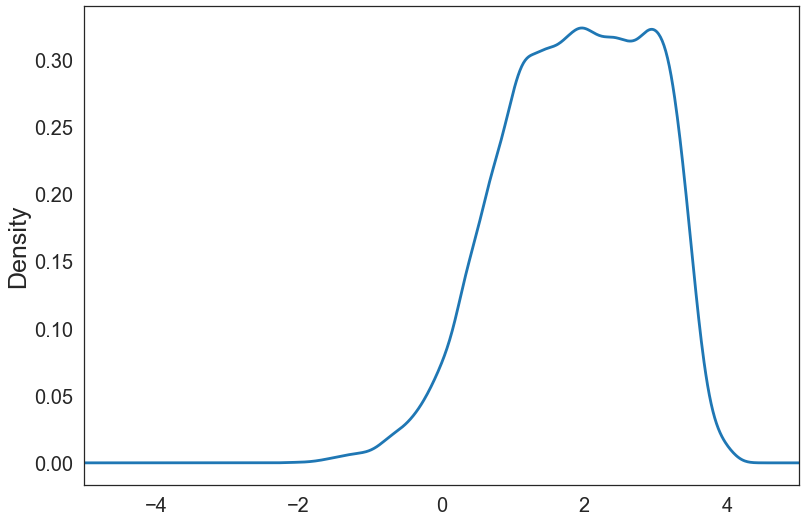

In [26]:
chembl_np_std_tauto_np = pd.read_csv("../tmp/chembl_np_std_tauto_np.tsv", sep="\t")
chembl_np_std_tauto_np["NP_Score"].plot.density()
plt.xlim(-5.0, 5.0);

In [29]:
chembl_np_std_tauto_np = pd.read_csv("../tmp/chembl_np_deglyco_std_tauto_np.tsv", sep="\t")
len(chembl_np_std_tauto_np)

30655

#### Representative Subset

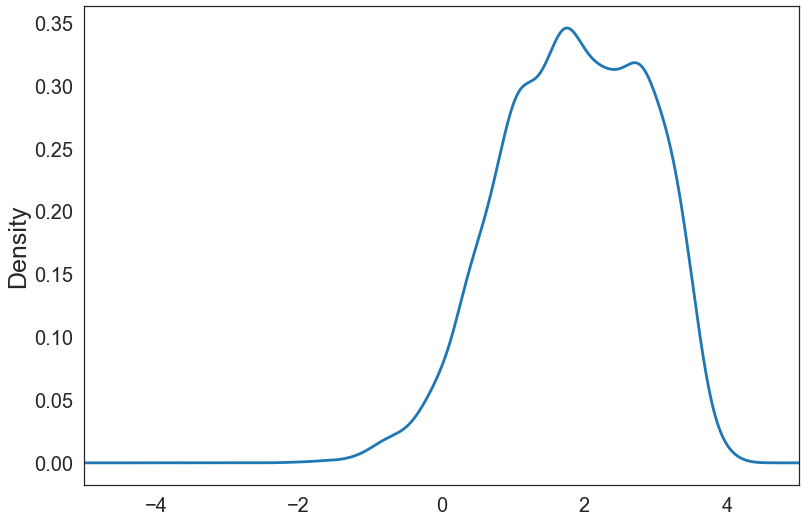

In [33]:
chembl_np_sub = chembl_np_std_tauto_np.sample(n=5000)
chembl_np_sub["NP_Score"].plot.density()
plt.xlim(-5.0, 5.0);

In [36]:
chembl_np_sub = chembl_np_sub[["Smiles", "Chembl_Id"]]
chembl_np_sub.to_csv("../tmp/chembl_np_sub.tsv", sep="\t", index=False)

## Analyticon

`acdiscnp-substances.tsv`  
Analyticon data set, downloaded as CSV file from ZINC15 on 19-Nov-2020,
converted to tab-separated file.

* 14600 cpds.
* xxx cpds. after deglycosylation, standardization and deduplication

### Deglycosylation, then Standardization

#### Loading and Initial Standardization

In [5]:
analyt = pd.read_csv("file:///home/pahl/comas/notebooks/sdf/analyticon/acdiscnp-substances.tsv", sep="\t")
analyt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14600 entries, 0 to 14599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Zinc_id  14600 non-null  object
 1   Smiles   14600 non-null  object
dtypes: object(2)
memory usage: 228.2+ KB


In [6]:
analyt.head()

,Zinc_id,Smiles
0,ZINC000000000566,COc1ccc2ccc(=O)oc2c1CC=C(C)C
1,ZINC000000001021,O=C(OCc1ccccc1)c1ccccc1
2,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O
3,ZINC000000001419,Cc1c(O)c(C)c2c(c1O)C(=O)C[C@H](c1ccc(O)cc1)O2
4,ZINC000000001669,CC(O)(CC(=O)O)CC(=O)O


In [7]:
# Initial standardization, before deglycosylation
# Takes 1min
analyt = u.apply_to_smiles(analyt, "Smiles", {"Smiles_Std": lambda x: u.standardize_mol(x, remove_stereo=True)})
analyt.drop("Smiles", axis=1, inplace=True)
analyt = analyt.rename(columns={"Smiles_Std": "Smiles"})

In [8]:
analyt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14600 entries, 0 to 14599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Zinc_id  14600 non-null  object
 1   Smiles   14600 non-null  object
dtypes: object(2)
memory usage: 228.2+ KB


In [9]:
# Takes xxxmin
analyt = u.filter_mols(analyt, "Smiles", ["Isotopes", "MedChemAtoms", "MinHeavyAtoms", "Duplicates"])
analyt.info()

Applying filters (4)...



Applied filter Isotopes: 14600



Applied filter MedChemAtoms: 14600



Applied filter MinHeavyAtoms: 14600



Applied filter Duplicates: 5051
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5051 entries, 0 to 14599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Zinc_id  5051 non-null   object
 1   Smiles   5051 non-null   object
dtypes: object(2)
memory usage: 118.4+ KB


In [10]:
analyt.head(10)

,Zinc_id,Smiles
0,ZINC000000000566,COc1ccc2ccc(=O)oc2c1CC=C(C)C
1,ZINC000000001021,O=C(OCc1ccccc1)c1ccccc1
2,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O
3,ZINC000000001419,Cc1c(O)c(C)c2c(c1O)C(=O)CC(c1ccc(O)cc1)O2
4,ZINC000000001669,CC(O)(CC(=O)O)CC(=O)O
5,ZINC000000001712,COC(=O)c1ccc(O)cc1
6,ZINC000000001758,COc1c(C)c2c(c(O)c1CC=C(C)CCC(=O)O)C(=O)OC2
7,ZINC000000001785,O=C1CC(c2ccc(O)cc2)Oc2cc(O)cc(O)c21
8,ZINC000000001795,O=C(O)c1cccnc1
9,ZINC000000001904,CC(C)=CCOc1c2occc2cc2ccc(=O)oc12


In [11]:
analyt.to_csv("../tmp/analyt.tsv", sep="\t", index=False)

#### Deglycosylation

Deglycosylation is performed using the KNIME Sugar Remover node (CDK).  
Here, the result of the deglycosylation is loaded again.

In [12]:
# Reading in the output of the KNIME workflow:
analyt = pd.read_csv("../tmp/analyt_deglyco.tsv", sep="\t")
analyt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4936 entries, 0 to 4935
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Zinc_id  4936 non-null   object
 1   Smiles   4936 non-null   object
dtypes: object(2)
memory usage: 77.2+ KB


In [13]:
# 2nd standardization and cleanup after deglycosylation
analyt_std = u.apply_to_smiles(analyt, "Smiles", {"Smiles_Std": u.standardize_mol})
analyt_std.drop("Smiles", axis=1, inplace=True)
analyt_std = analyt_std.rename(columns={"Smiles_Std": "Smiles"})
analyt_std.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4936 entries, 0 to 4935
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Zinc_id  4936 non-null   object
 1   Smiles   4936 non-null   object
dtypes: object(2)
memory usage: 77.2+ KB


In [14]:
analyt = u.filter_mols(analyt, "Smiles", ["MinHeavyAtoms", "MaxHeavyAtoms", "Duplicates"])

Applying filters (3)...



Applied filter MinHeavyAtoms: 4922
Applied filter MaxHeavyAtoms: 4922



Applied filter Duplicates: 4300


#### Final Standardization

Including tautomerization.

In [15]:
# Takes 5min
analyt_std_tauto = u.apply_to_smiles(analyt_std, "Smiles", {"Smiles_Std": lambda x: u.standardize_mol(x, canonicalize_tautomer=True)})

In [16]:
analyt_std_tauto.drop("Smiles", axis=1, inplace=True)
analyt_std_tauto = analyt_std_tauto.rename(columns={"Smiles_Std": "Smiles"})

In [17]:
analyt_std_tauto = u.filter_mols(analyt_std_tauto, "Smiles", "Duplicates")

Applying filters (1)...



Applied filter Duplicates: 4171


In [20]:
analyt_std_tauto.to_csv("../tmp/analyt_deglyco_std_tauto.tsv", sep="\t", index=False)
analyt_std_tauto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4171 entries, 0 to 4935
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Zinc_id  4171 non-null   object
 1   Smiles   4171 non-null   object
dtypes: object(2)
memory usage: 97.8+ KB


In [21]:
analyt_std_tauto.head()

,Zinc_id,Smiles
0,ZINC000000000566,COc1ccc2ccc(=O)oc2c1CC=C(C)C
1,ZINC000000001021,O=C(OCc1ccccc1)c1ccccc1
2,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O
3,ZINC000000001419,Cc1c(O)c(C)c2c(c1O)C(=O)CC(c1ccc(O)cc1)O2
4,ZINC000000001669,CC(O)(CC(=O)O)CC(=O)O


#### Add NP Likeness Score

In [22]:
# chembl_np_std_tauto = pd.read_csv("../tmp/analyt_deglyco_std_tauto.tsv", sep="\t")
analyt_std_tauto_np = u.apply_to_smiles(analyt_std_tauto, "Smiles", {"NP_Score": score_np})
len(analyt_std_tauto_np)

4171

In [23]:
analyt_std_tauto_np = analyt_std_tauto_np[~analyt_std_tauto_np["NP_Score"].isnull()]
analyt_std_tauto_np.to_csv("../tmp/analyt_deglyco_std_tauto_np.tsv", sep="\t", index=False)
len(analyt_std_tauto_np)

4171

#### Plot Distribution

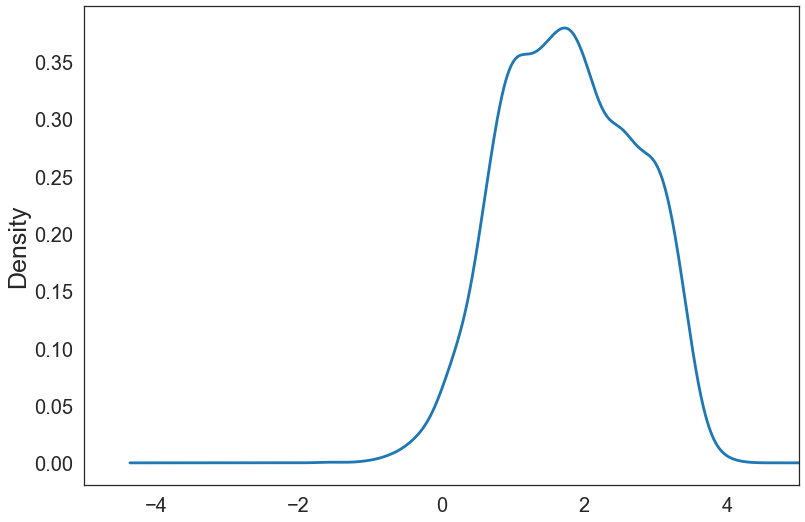

In [24]:
# analyt_std_tauto_np = pd.read_csv("../tmp/analyt_deglyco_std_tauto_np.tsv", sep="\t")
analyt_std_tauto_np["NP_Score"].plot.density()
plt.xlim(-5.0, 5.0);

In [30]:
comb = pd.concat([chembl_np_std_tauto_np, analyt_std_tauto_np])
len(comb)

34826

In [31]:
comb = u.filter_mols(comb, "Smiles", "Duplicates")
len(comb)

Applying filters (1)...



Applied filter Duplicates: 33481


33481